In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import hvplot.xarray
import hvplot.pandas
# import netCDF4
import geopandas as gpd
# from geopandas import GeoDataFrame
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
import glob
import os
from bokeh.models.formatters import DatetimeTickFormatter

In [2]:
# import warnings
# warnings.filterwarnings("ignore")

In [3]:
## Note: if cfeatures do not work, download manually to directory: 
# import cartopy 
# print(cartopy.config['data_dir'])

In [4]:
def get_single_match(pattern):
    matches = glob.glob(pattern)
    if len(matches) == 1:
        return matches[0]
    elif len(matches) == 0:
        raise ValueError(f"No matches found")
    else:
        raise ValueError(f"Multiple matches found: {matches}")

In [5]:
proj=ccrs.PlateCarree()

## AmeriFlux

In [6]:
site_ID =  'US-A32'

filepath = 'ameriflux-data/'
meta_file = filepath + 'AmeriFlux-site-search-results-202410071335.tsv'
ameriflux_meta = pd.read_csv(meta_file, sep='\t')
site_meta = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID]
site_meta

,Site ID,Name,Principal Investigator,Data Use Policy,AmeriFlux BASE Data,AmeriFlux FLUXNET Data,Vegetation Abbreviation (IGBP),Vegetation Description (IGBP),Climate Class Abbreviation (Koeppen),Climate Class Description (Koeppen),...,Longitude (degrees),Elevation (m),Years of AmeriFlux BASE Data,AmeriFlux BASE DOI,Years of AmeriFlux FLUXNET Data,AmeriFlux FLUXNET DOI,Site Start,Site End,BASE variables available,FLUXNET variables available
133,US-A32,ARM-SGP Medford hay pasture,Sebastien Biraud (scbiraud@lbl.gov),CC-BY-4.0,Yes,Yes,GRA,Grasslands: Lands with herbaceous types of cov...,Cfa,"Humid Subtropical: mild with no dry season, ho...",...,-97.8198,335.0,"2015, 2016, 2017",https://doi.org/10.17190/AMF/1436327,"2015, 2016, 2017",https://doi.org/10.17190/AMF/1881568,2015.0,2017.0,"ALB, CO2, FC, G, H, H2O, LE, LW_IN, LW_OUT, ND...",NaN


In [7]:
# Import site metadata csv
filepath = 'ameriflux-data/'
ameriflux_meta = pd.read_csv(filepath + 'AmeriFlux-site-search-results-202410071335.tsv', sep='\t')
fluxnet_meta = ameriflux_meta.loc[ameriflux_meta['AmeriFlux FLUXNET Data'] == 'Yes'] #use FLUXNET only
fluxnet_simple = fluxnet_meta[['Site ID', 'Longitude (degrees)', 'Latitude (degrees)', 'Years of AmeriFlux FLUXNET Data']] #drop unneeded columns

fluxnet_simple

,Site ID,Longitude (degrees),Latitude (degrees),Years of AmeriFlux FLUXNET Data
5,AR-TF1,-66.7335,-54.9733,"2016, 2017, 2018"
9,BR-CST,-38.3842,-7.9682,"2014, 2015"
18,BR-Npw,-56.4120,-16.4980,"2013, 2014, 2015, 2016, 2017"
25,CA-ARB,-83.9452,52.6950,"2011, 2012, 2013, 2014, 2015"
26,CA-ARF,-83.9550,52.7008,"2011, 2012, 2013, 2014, 2015"
...,...,...,...,...
664,US-xTR,-89.5857,45.4937,"2017, 2018, 2019, 2020, 2021"
665,US-xUK,-95.1921,39.0404,"2017, 2018, 2019, 2020, 2021"
666,US-xUN,-89.5373,46.2339,"2017, 2018, 2019, 2020, 2021"
667,US-xWD,-99.2414,47.1282,"2019, 2020, 2021"


In [8]:
# Select one site
site_ID =  'US-A32'
site_sel_meta = fluxnet_simple.loc[fluxnet_simple['Site ID'] == site_ID]
site_sel_meta

,Site ID,Longitude (degrees),Latitude (degrees),Years of AmeriFlux FLUXNET Data
133,US-A32,-97.8198,36.8193,"2015, 2016, 2017"


In [9]:
site_lat, site_lon = site_sel_meta['Latitude (degrees)'].values, site_sel_meta['Longitude (degrees)'].values

In [10]:
# year_start = site_sel_meta['Years of AmeriFlux FLUXNET Data'].str.split(', ').str[0].values[0]
# year_end = site_sel_meta['Years of AmeriFlux FLUXNET Data'].str.split(', ').str[-1].values[0]
# print(year_start,year_end)
# site_filename = 'ameriflux-data/AMF_' + site_ID + '_FLUXNET_SUBSET_' + year_start + '-' + year_end +'*'
# print(site_filename)

In [11]:
# Import selected site half-hourly data (HH) Subset data
filepath = 'ameriflux-data/'
sel_file = get_single_match(filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_HH_*.csv')
fluxnet_sel = pd.read_csv(sel_file)
# fluxnet_sel.head()

In [12]:
# select subset of columns + create datetime index
# sel_sub = fluxnet_sel[['TIMESTAMP_START','TIMESTAMP_END', 'NEE_VUT_REF','NEE_VUT_REF_QC']]
fluxnet_sel_simple = fluxnet_sel[['TIMESTAMP_START','TIMESTAMP_END', 'NEE_VUT_REF']]
fluxnet_sel_simple .index = pd.to_datetime(fluxnet_sel_simple ['TIMESTAMP_START'],format='%Y%m%d%H%M')
fluxnet_sel_simple.index.names = ['time']

In [33]:
# Convert and resample
# FluxNet NEE_VUT_REF (umolCO2 m-2 s-1) to MiCASA (kgC m-2 s-1)
fluxnet_sel_final = fluxnet_sel_simple['NEE_VUT_REF']*1e-6*12.01*1e-3

# resample to 3-hourly per MiCASA
fluxnet_sel_final = fluxnet_sel_final.resample('3h').mean()
print(len(fluxnet_sel_final))

# Option to convert to xarray
# fluxnet_sel_final = fluxnet_sel_final.resample('3h').mean().to_xarray()
# fluxnet_sel_final.assign_attrs(
    # units="kg m-2 s-1", expressed_as='carbon')

fluxnet_sel_final.name = 'FluxNET NEE (kgC m-2 s-1)'
fluxnet_sel_final.hvplot()

8768


:Curve   [time]   (FluxNET NEE (kgC m-2 s-1))

In [46]:
fluxnet_sel_final

time
2015-01-01 00:00:00    9.263231e-08
2015-01-01 03:00:00    8.939812e-08
2015-01-01 06:00:00   -5.619559e-08
2015-01-01 09:00:00   -2.829282e-07
2015-01-01 12:00:00   -2.676370e-07
                           ...     
2017-12-31 09:00:00   -7.665004e-08
2017-12-31 12:00:00   -1.370172e-07
2017-12-31 15:00:00   -7.446530e-08
2017-12-31 18:00:00    1.048774e-07
2017-12-31 21:00:00    9.921883e-08
Freq: 3h, Name: FluxNET NEE (kgC m-2 s-1), Length: 8768, dtype: float64

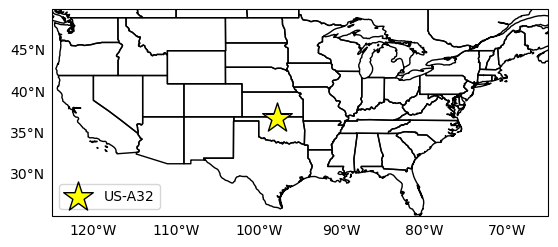

In [14]:
# Plot selected site
# subset CONUS
min_lon, max_lon = -125, -65
min_lat, max_lat = 25, 50

fig, ax = plt.subplots(subplot_kw= {'projection': proj});
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=proj);
ax.add_feature(cfeature.STATES)
ax.scatter(site_lon,site_lat,
           marker='*', 
           s=500,
           color='yellow',
           edgecolor='black', zorder=3, label=f'{site_ID}')

ax.legend(loc='lower left')
gl = ax.gridlines(draw_labels=True,x_inline=False, y_inline=False,color = "None")
gl.top_labels = False
gl.right_labels = False

## MiCASA

In [15]:
# Create a list of unique dates from the site
time = fluxnet_sel_final.index
# if xarray:
# time = fluxnet_sel_final.time.to_index()

dates_unique = list({dt.date() for dt in time})
dates_unique.sort()
len(dates_unique)

1096

In [34]:
# loop over dates
data_path = 'micasa-data/daily-0.1deg-final/holding/3hrly/'
path_list = []

for date in dates_unique[:3]: #only partial load for speed
# for date in dates_unique:
    f_year = str(date.year)
    f_month = f"{date.month:02}"
    filename = 'MiCASA_v1_flux_*' + date.strftime('%Y%m%d') + '.nc4'
    filepath = get_single_match(os.path.join(data_path,f_year,f_month,filename))
    path_list.append(filepath)

In [35]:
ds = xr.open_mfdataset(path_list)['NEE']

In [36]:
# Select grid closest to selected site
ds_subset = ds.sel(lon=site_lon, lat=site_lat, method='nearest')
ds_subset

<xarray.DataArray 'NEE' (time: 24, lat: 1, lon: 1)> Size: 96B
dask.array<getitem, shape=(24, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 8B 36.85
  * lon      (lon) float64 8B -97.85
  * time     (time) datetime64[ns] 192B 2015-01-01 ... 2015-01-03T21:00:00
Attributes:
    units:         kg m-2 s-1
    expressed_as:  carbon
    long_name:     Net ecosystem exchange

In [52]:
ds_subset

<xarray.DataArray 'NEE' (time: 24, lat: 1, lon: 1)> Size: 96B
dask.array<getitem, shape=(24, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 8B 36.85
  * lon      (lon) float64 8B -97.85
  * time     (time) datetime64[ns] 192B 2015-01-01 ... 2015-01-03T21:00:00
Attributes:
    units:         kg m-2 s-1
    expressed_as:  carbon
    long_name:     Net ecosystem exchange

In [66]:
# prep data for writing to csv
ds_out = ds_subset.squeeze(dim=['lat','lon'],drop=True).to_dataframe()
ds_out = ds_out.rename(columns={'NEE': 'MiCASA NEE (kgC m-2 s-1)'})
ds_out

,MiCASA NEE (kgC m-2 s-1)
time,
2015-01-01 00:00:00,4.376675e-09
2015-01-01 03:00:00,4.236837e-09
2015-01-01 06:00:00,4.143609e-09
2015-01-01 09:00:00,4.105323e-09
2015-01-01 12:00:00,3.566877e-09
2015-01-01 15:00:00,-1.619836e-09
2015-01-01 18:00:00,-2.215107e-09
2015-01-01 21:00:00,3.168927e-09
2015-01-02 00:00:00,5.398913e-09


In [69]:
# write to csv
output_dir = 'output'
output_filename = f'{site_ID}_micasa'
output_path = os.path.join(output_dir, output_filename)

os.makedirs(output_dir, exist_ok=True)

ds_out.to_csv(output_path)

In [19]:
# # Test plot with grid cell
# # Subset region of selected site
# min_lon_mesh, max_lon_mesh = -99,-97
# min_lat_mesh, max_lat_mesh = 36, 37.5
# # min_lon_mesh, max_lon_mesh = -100,-95
# # min_lat_mesh, max_lat_mesh = 33,39

# fig, ax = plt.subplots(figsize=(8,6),subplot_kw= {'projection': proj});
# ax.set_extent([min_lon_mesh, max_lon_mesh, min_lat_mesh, max_lat_mesh], crs=proj);
# ax.add_feature(cfeature.STATES)

# # Plot FluxNet tower
# ax.scatter(site_lon,site_lat,
#            color='red',
#            s=80,
#            label=f'FluxNet {site_ID}')

# # Plot nearest miCASA point
# ax.scatter(ds_subset.lon, ds_subset.lat,
#         color='darkviolet',
#         s=80,
#         label='Nearest MiCASA point',
#         )
                                    
# # Plot xarray mesh underneath
# ds_subset_mesh = ds.sel(lon=slice(min_lon_mesh, max_lon_mesh), lat=slice(min_lat_mesh, max_lat_mesh))
# ds_subset_mesh.isel(time=0).plot(ax=ax, transform=proj,
#                                  zorder=0
#                                 # cbar_kwargs={"location": "bottom"}
#                                 )
# ax.legend(loc='lower left')
# gl = ax.gridlines(
#     xlocs = np.arange(min_lon_mesh-1,max_lon_mesh+1,0.5),
#     ylocs = np.arange(min_lat_mesh-1,max_lat_mesh+1,0.5),
#     draw_labels=True,
#     # x_inline=False, y_inline=False,
#     color = "None")
# gl.top_labels = False
# gl.right_labels = False

In [20]:
# ds_subset.load().head()

In [21]:
# fluxnet_sel_final

In [25]:
# Combine datasets and plot
# combined = xr.merge([ds_subset,fluxnet_sel_final])
# combined = combined.rename({'NEE': 'MiCASA', 'NEE_VUT_REF': 'FluxNet'})

In [ ]:
# formatter = DatetimeTickFormatter(months='%b %Y')

# combined.hvplot(
#     kind='line',
#     groupby=['time.year', 'time.month'],
#     xformatter=formatter,
#     ylabel = 'NEE (kg C m-2 s-1)',
#     title = f'{site_ID}'
    
# )

# Try Another location

# Dump

In [ ]:
# vmin = -max(abs(ds_subset.min().values),abs(ds_subset.max().values))
# vmax = max(abs(ds_subset.min().values),abs(ds_subset.max().values))

# ds_subset.hvplot(cmap='seismic',groupby='time', clim=(vmin,vmax),
#              geo=True, 
#             projection=proj,
#             xlim=(min_lon, max_lon), 
#             ylim=(min_lat, max_lat),
#             # widget_type="scrubber", 
#             framewise=True,
#             widget_location="bottom",)

In [ ]:
# # Plot both datasets
# formatter = DatetimeTickFormatter(months='%b %Y')

# micasa = ds_subset.hvplot(
#     kind='line',
#     label = 'MiCASA',
#     groupby=['time.year', 'time.month'],
#     framewise=True,
#     xformatter=formatter
#                 )

# fluxnet = sel_resample.hvplot(
#     label=f'FluxNet {site_ID}',
#     groupby=['time.year', 'time.month'],      
#     framewise=True,
#     xformatter=formatter
# )

# combined = fluxnet * micasa
# combined.opts(legend_position='bottom_left')